## Code to determine the 1, 2 and 3 star opportunities for the shots 

### Reading data, model and checking datatypes

In [1]:
import os
import numpy as np

os.chdir("/Users/sakshamarora/Documents/6748 Practicum/project/GT_MSA_LBA")

In [2]:
league = 'NCAAM1'
season = '22-23'
threshold_var = input("Would you like to use previous thresholds or create new ones? (Answer 1 for Yes and 0 for No)")

if threshold_var == '1':
    print(f"Running the notebook for {league} {season} season with usage of previous thresholds ({league}_{season}_threshold.csv)")
else:
    print(f"Running the notebook for {league} {season} season with new thresholds (you will choose after graphical evaluation)")

Running the notebook for NCAAM1 22-23 season with new thresholds (you will choose after graphical evaluation)


In [3]:
import pandas as pd
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

#### Loading the model objects

In [4]:
model_2p_NCAAM = lgb.Booster(model_file=f'Inference/2p_{league}_{season}_model.txt')
model_3p_NCAAM = lgb.Booster(model_file=f'Inference/3p_{league}_{season}_model.txt')

In [5]:
features_2p_men = list(model_2p_NCAAM.feature_name())
features_3p_men = list(model_3p_NCAAM.feature_name())

#### Reading data

In [6]:
data_2p = pd.read_pickle(f'data/processed_data/{league}_{season}_2P.pickle')
data_3p = pd.read_pickle(f'data/processed_data/{league}_{season}_3P.pickle')

In [7]:
def clean_column_names(df):
    df.columns = df.columns.str.replace('[{}:,"]', '', regex=True)  # Replace special JSON characters
    df.columns = df.columns.str.replace(' ', '_')  # Replace spaces with underscores
    return df

data_2p = clean_column_names(data_2p)
data_3p = clean_column_names(data_3p)

def cast_to_categorical(df):
    object_cols = df.select_dtypes(include=['object']).columns
    df[object_cols] = df[object_cols].astype('category')
    return df

data_2p = cast_to_categorical(data_2p)
data_3p = cast_to_categorical(data_3p)

print(data_2p.shape)
print(data_3p.shape)

(436328, 147)
(261971, 147)


In [8]:
display(data_2p.head())
display(data_3p.head())

,game_id,team_id,season_id,player_id,shot_id,segment_id,Distance,Angle,Zone,x_coordinate,y_coordinate,Period,Time_Seconds,Time,score,score_opp,Stat,Jumpshot,Assisted,Red_Zone,Floater,Second_Chance,Layup,Paint,Drive,Blocked,ATO,Off_Turnover,Off_Steal,Hook_Shot,Fastbreak,Pullup,And1,Turnaround,Dunk,Step_Back,season,league,date,has_locations,has_segments,team1,team2,hometeam,winning_team,Location,w_l_ratio_last_10,opp_w_l_ratio_last_10,w_l_ratio_last_5,opp_w_l_ratio_last_5,w_l_ratio_last_3,opp_w_l_ratio_last_3,w_l_ratio_last_1,opp_w_l_ratio_last_1,height,LBA_position,year,team_wl_ratio_prev_season,opp_team_wl_ratio_prev_season,score_pre_shot,score_pre_shot_diff,clutch_time,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,current_season_usage_ratio,past_season_usage_ratio,Big,Mid,Small,Made,D1,L1_Zone_made,L1_Zone_attempted,L1_Zone_perc%,L3_Zone_made,L3_Zone_attempted,L3_Zone_perc%,L5_Zone_made,L5_Zone_perc%,L5_Zone_attempted,L10_Zone_made,L10_Zone_attempted,L10_Zone_perc%,TOT_Zone_made,TOT_Zone_attempted,TOT_Zone_perc%,Shot_type,L1_Shot_type_made,L1_Shot_type_attempted,L1_Shot_type_perc%,L3_Shot_type_made,L3_Shot_type_attempted,L3_Shot_type_perc%,L5_Shot_type_made,L5_Shot_type_attempted,L5_Shot_type_perc%,L10_Shot_type_made,L10_Shot_type_attempted,L10_Shot_type_perc%,TOT_Shot_type_made,TOT_Shot_type_attempted,TOT_Shot_type_perc%,Last_season_Shot_type_made,Last_season_Shot_type_attempted,Last_season_Shot_type_perc%,Last_season_Zone_made,Last_season_Zone_attempted,Last_season_Zone_perc%,L1_played,L1_2PM,L1_2PA,L1_2P%,L1_Jumpshots_assisted_on,L1_Jumpshots_assisted%,L3_played,L3_2PM,L3_2PA,L3_2P%,L3_Jumpshots_assisted_on,L3_Jumpshots_assisted%,L5_played,L5_2PM,L5_2PA,L5_2P%,L5_Jumpshots_assisted_on,L5_Jumpshots_assisted%,L10_played,L10_2PM,L10_2PA,L10_2P%,L10_Jumpshots_assisted_on,L10_Jumpshots_assisted%,TOT_played,TOT_2PM,TOT_2PA,TOT_2P%,TOT_Jumpshots_assisted_on,TOT_Jumpshots_assisted%,Last_season_played,Last_season_2PM,Last_season_2PA,Last_season_2P%,Last_season_Jumpshots_assisted_on,Last_season_Jumpshots_assisted%
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,15.94,75.5,4-2,21.0,20.7,1,1091,18:11,3,2,TwoMiss,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,22-23,NCAAM1+,2022-11-07,True,True,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,Small,Sr,0.419355,0.741935,3,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,4,1,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Floater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,12.54,28.7,3-1,14.0,11.3,1,1086,18:6,3,2,TwoMiss,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,22-23,NCAAM1+,2022-11-07,True,True,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,Small,So,0.419355,0.741935,3,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,4,1,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jumpshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,11.67,

,game_id,team_id,season_id,player_id,shot_id,segment_id,Distance,Angle,Zone,x_coordinate,y_coordinate,Period,Time_Seconds,Time,score,score_opp,Stat,Jumpshot,Assisted,Red_Zone,Floater,Second_Chance,Layup,Paint,Drive,Blocked,ATO,Off_Turnover,Off_Steal,Hook_Shot,Fastbreak,Pullup,And1,Turnaround,Dunk,Step_Back,season,league,date,has_locations,has_segments,team1,team2,hometeam,winning_team,Location,w_l_ratio_last_10,opp_w_l_ratio_last_10,w_l_ratio_last_5,opp_w_l_ratio_last_5,w_l_ratio_last_3,opp_w_l_ratio_last_3,w_l_ratio_last_1,opp_w_l_ratio_last_1,height,LBA_position,year,team_wl_ratio_prev_season,opp_team_wl_ratio_prev_season,score_pre_shot,score_pre_shot_diff,clutch_time,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,current_season_usage_ratio,past_season_usage_ratio,Big,Mid,Small,Made,D1,L1_Zone_made,L1_Zone_attempted,L1_Zone_perc%,L3_Zone_made,L3_Zone_attempted,L3_Zone_perc%,L5_Zone_made,L5_Zone_attempted,L5_Zone_perc%,L10_Zone_made,L10_Zone_attempted,L10_Zone_perc%,TOT_Zone_made,TOT_Zone_attempted,TOT_Zone_perc%,Last_season_Zone_made,Last_season_Zone_attempted,Last_season_Zone_perc%,Shot_type,L1_Shot_type_made,L1_Shot_type_attempted,L1_Shot_type_perc%,L3_Shot_type_made,L3_Shot_type_attempted,L3_Shot_type_perc%,L5_Shot_type_made,L5_Shot_type_attempted,L5_Shot_type_perc%,L10_Shot_type_made,L10_Shot_type_attempted,L10_Shot_type_perc%,TOT_Shot_type_made,TOT_Shot_type_attempted,TOT_Shot_type_perc%,Last_season_Shot_type_made,Last_season_Shot_type_attempted,Last_season_Shot_type_perc%,L1_played,L1_3PM,L1_3PA,L1_3P%,L1_3P_Jumpshots_assisted_on,L1_3P_Jumpshots_assisted%,L3_played,L3_3PM,L3_3PA,L3_3P%,L3_3P_Jumpshots_assisted_on,L3_3P_Jumpshots_assisted%,L5_played,L5_3PM,L5_3PA,L5_3P%,L5_3P_Jumpshots_assisted_on,L5_3P_Jumpshots_assisted%,L10_played,L10_3PM,L10_3PA,L10_3P%,L10_3P_Jumpshots_assisted_on,L10_3P_Jumpshots_assisted%,TOT_played,TOT_3PM,TOT_3PA,TOT_3P%,TOT_3P_Jumpshots_assisted_on,TOT_3P_Jumpshots_assisted%,Last_season_played,Last_season_3PM,Last_season_3PA,Last_season_3P%,Last_season_3P_Jumpshots_assisted_on,Last_season_3P_Jumpshots_assisted%
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe48,636a5fa6531336e79c3425dd,636a5f91531336e79c3425b4,25.26,37.7,7-1,5.0,20.7,1,1130,18:50,3,2,ThreeMake,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,22-23,NCAAM1+,2022-11-07,True,True,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,Mid,Sr,0.419355,0.741935,0,-2,0,0,NaN,NaN,NaN,NaN,NaN,0.155364,0,4,1,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.035714,0.035714,1.000000,Jumpshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.071429,3.214286,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,1.071429,3.214286,0.333333,28.0,0.933333
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f44ed05764db467fe45,636a5fa6531336e79c3425fc,636a5f91531336e79c3425b7,27.14,108.3,7-2,33.5,31.0,1,786,13:6,7,12,ThreeMiss,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,22-23,NCAAM1+,2022-11-07,True,True,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,Mid,Sr,0.419355,0.741935,7,-5,0,0,NaN,NaN,NaN,NaN,NaN,0.362105,0,4,1,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1.000000,0.000000,Jumpshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,3.000000,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.000000,3.000000,0.333333,1.0,1.000000
2,636a5

In [9]:
print(data_2p[features_2p_men].dtypes)
print(data_2p[features_2p_men].shape)

Fastbreak                              bool
Distance                            float64
Dunk                                   bool
Jumpshot                               bool
Red_Zone                               bool
Off_Steal                              bool
height                              float64
Drive                                  bool
opp_team_wl_ratio_prev_season       float64
Last_season_Shot_type_perc%         float64
TOT_Zone_made                       float64
TOT_Shot_type_perc%                 float64
Layup                                  bool
TOT_2P%                             float64
Last_season_Shot_type_attempted     float64
score_pre_shot                        int64
Angle                               float64
x_coordinate                        float64
Big                                   int64
TOT_Shot_type_made                  float64
Time_Seconds                          int64
Shot_type                          category
Zone                            

In [10]:
print(data_3p[features_3p_men].dtypes)
print(data_3p[features_3p_men].shape)

Time_Seconds                          int64
Distance                            float64
TOT_3PM                             float64
y_coordinate                        float64
opp_team_wl_ratio_prev_season       float64
score_pre_shot_diff                   int64
opp_w_l_ratio_last_10               float64
Last_season_3P%                     float64
team_wl_ratio_prev_season           float64
last_1_game_usage_ratio             float64
score_pre_shot                        int64
L10_3P%                             float64
Last_season_Shot_type_attempted     float64
Jumpshot                               bool
last_10_game_usage_ratio            float64
Angle                               float64
past_season_usage_ratio             float64
TOT_Shot_type_perc%                 float64
L5_3P_Jumpshots_assisted%           float64
Location                           category
dtype: object
(261971, 20)


### Predict on the 2 and 3 pointer datasets to get probabilities

In [11]:
predictions_2p = model_2p_NCAAM.predict(data_2p[features_2p_men])
data_2p['predictions'] = predictions_2p

data_two_miss = data_2p[data_2p['Stat'] == 'TwoMiss']['predictions']
data_two_make = data_2p[data_2p['Stat'] == 'TwoMake']['predictions']

In [12]:
predictions_3p = model_3p_NCAAM.predict(data_3p[features_3p_men])
data_3p['predictions'] = predictions_3p

data_three_miss = data_3p[data_3p['Stat'] == 'ThreeMiss']['predictions']
data_three_make = data_3p[data_3p['Stat'] == 'ThreeMake']['predictions']

### Plotting the distributions of 2 pointers, 3 pointers and combined

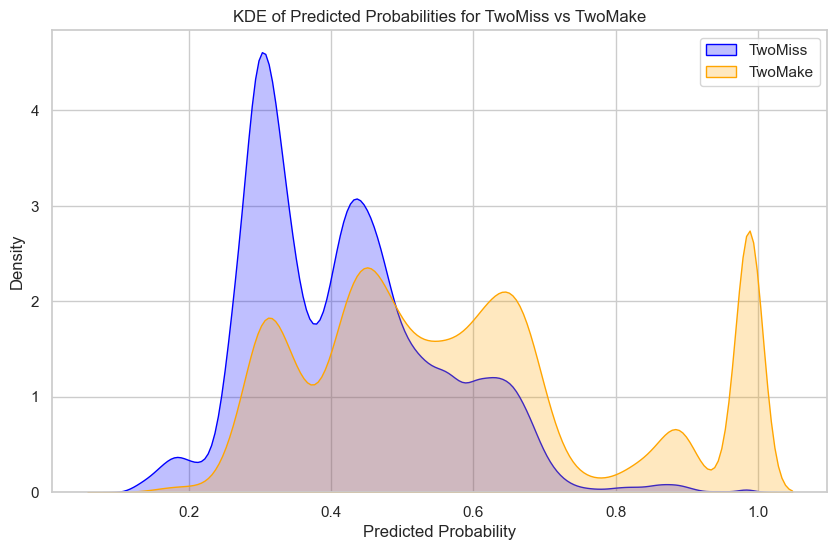

In [13]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.kdeplot(data_two_miss, label='TwoMiss', fill=True, color='blue')
sns.kdeplot(data_two_make, label='TwoMake', fill=True, color='orange')

plt.title('KDE of Predicted Probabilities for TwoMiss vs TwoMake')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')

plt.legend()
plt.show()

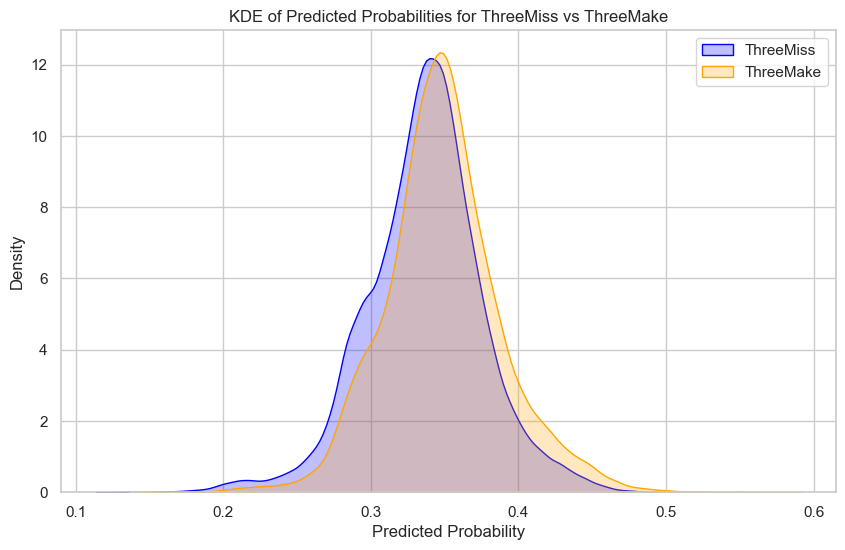

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.kdeplot(data_three_miss, label='ThreeMiss', fill=True, color='blue')
sns.kdeplot(data_three_make, label='ThreeMake', fill=True, color='orange')

plt.title('KDE of Predicted Probabilities for ThreeMiss vs ThreeMake')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')

plt.legend()
plt.show()

### Combining 2 and 3 pointers data together

In [15]:
common_columns = data_2p.columns.intersection(data_3p.columns)
data_2p_common = data_2p[common_columns]
data_3p_common = data_3p[common_columns]

combined_data = pd.concat([data_2p_common, data_3p_common], ignore_index=True)

print(combined_data.shape)

(698299, 118)


In [16]:
data_make = combined_data[combined_data['Stat'].str.contains('Make')]['predictions']
data_miss = combined_data[combined_data['Stat'].str.contains('Miss')]['predictions']

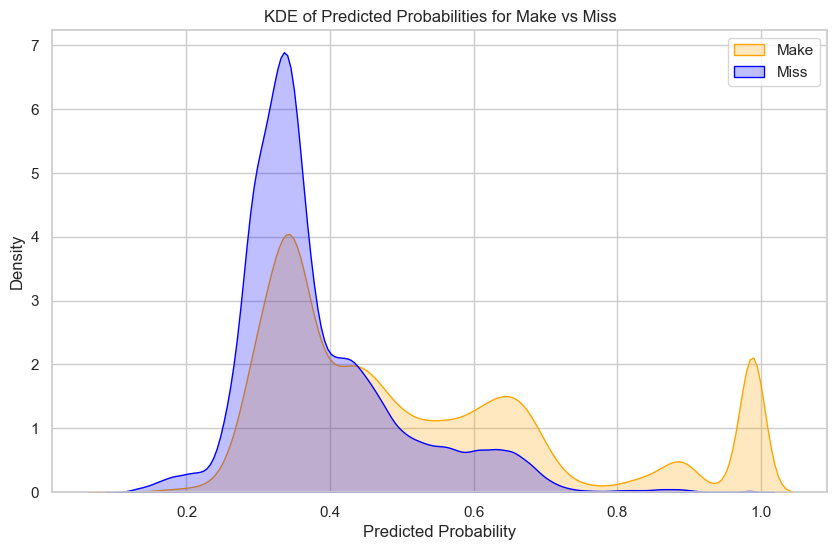

In [17]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.kdeplot(data_make, label='Make', fill=True, color='orange')
sns.kdeplot(data_miss, label='Miss', fill=True, color='blue')

plt.title('KDE of Predicted Probabilities for Make vs Miss')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')

plt.legend()
plt.show()

In [18]:
# print(combined_data['Stat'].value_counts())
combined_data['Shot_Pointer'] = combined_data['Stat'].apply(lambda x: 2 if 'Two' in x else 3)
# print(combined_data['Shot_Pointer'].value_counts())

In [19]:
combined_data['pps'] = combined_data.apply(
    lambda row: row['predictions'] * 2 if row['Shot_Pointer'] == 2 else row['predictions'] * 3,
    axis=1
)

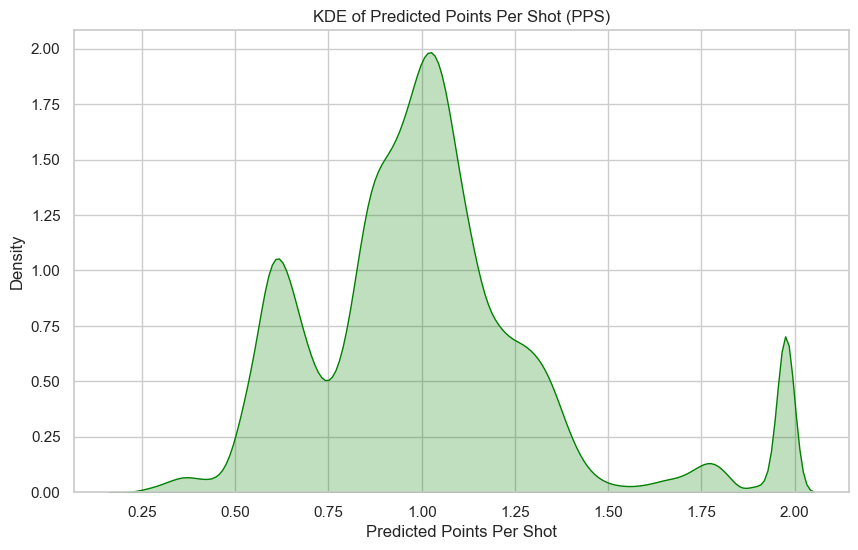

In [20]:
# Setting up the plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plotting KDE for pps
sns.kdeplot(combined_data['pps'], fill=True, color='green')

# Adding labels and title
plt.title('KDE of Predicted Points Per Shot (PPS)')
plt.xlabel('Predicted Points Per Shot')
plt.ylabel('Density')

# Show the plot
plt.show()


### Labelling 1 star, 2 star and 3 star shots based on predicted points per shot and user input 

In [21]:
def categorize_opportunities(df, pps_column, league, season):
    filename = f"Inference/{league}_{season}_threshold.csv"
    if threshold_var == '1':
        try:
            thresholds = pd.read_csv(filename)
            threshold_one, threshold_two = thresholds.iloc[0, 0], thresholds.iloc[0, 1]
        except FileNotFoundError:
            print(f"No previous thresholds found for {league}_{season}.")
            return
    else:
        threshold_one = float(input("Enter the threshold value for 2 star opportunity: "))
        threshold_two = float(input("Enter the threshold value for 3 star opportunity: "))

        pd.DataFrame([[threshold_one, threshold_two]]).to_csv(filename, index=False)

    percentile_one = df[pps_column].rank(pct=True).loc[df[pps_column] >= threshold_one].min()
    percentile_two = df[pps_column].rank(pct=True).loc[df[pps_column] >= threshold_two].min()
    
    print(f"The {percentile_one*100:.1f}% percentile corresponds to the threshold {threshold_one}")
    print(f"The {percentile_two*100:.1f}% percentile corresponds to the threshold {threshold_two}")

    def categorize(row):
        if row[pps_column] < threshold_one:
            return '1 Star'
        elif threshold_one <= row[pps_column] < threshold_two:
            return '2 Star'
        else:
            return '3 Star'

    df['Opportunity_Rating'] = df.apply(categorize, axis=1)
    return df

combined_data = categorize_opportunities(combined_data, 'pps', league, season)

The 19.9% percentile corresponds to the threshold 0.75
The 70.4% percentile corresponds to the threshold 1.1


In [22]:
print(combined_data.value_counts('Opportunity_Rating'))
combined_data.head()

Opportunity_Rating
2 Star    352580
3 Star    206854
1 Star    138865
Name: count, dtype: int64


,game_id,team_id,season_id,player_id,shot_id,segment_id,Distance,Angle,Zone,x_coordinate,y_coordinate,Period,Time_Seconds,Time,score,score_opp,Stat,Jumpshot,Assisted,Red_Zone,Floater,Second_Chance,Layup,Paint,Drive,Blocked,ATO,Off_Turnover,Off_Steal,Hook_Shot,Fastbreak,Pullup,And1,Turnaround,Dunk,Step_Back,season,league,date,has_locations,has_segments,team1,team2,hometeam,winning_team,Location,w_l_ratio_last_10,opp_w_l_ratio_last_10,w_l_ratio_last_5,opp_w_l_ratio_last_5,w_l_ratio_last_3,opp_w_l_ratio_last_3,w_l_ratio_last_1,opp_w_l_ratio_last_1,height,LBA_position,year,team_wl_ratio_prev_season,opp_team_wl_ratio_prev_season,score_pre_shot,score_pre_shot_diff,clutch_time,num_blockers_on_team,last_1_game_usage_ratio,last_3_game_usage_ratio,last_5_game_usage_ratio,last_10_game_usage_ratio,current_season_usage_ratio,past_season_usage_ratio,Big,Mid,Small,Made,D1,L1_Zone_made,L1_Zone_attempted,L1_Zone_perc%,L3_Zone_made,L3_Zone_attempted,L3_Zone_perc%,L5_Zone_made,L5_Zone_perc%,L5_Zone_attempted,L10_Zone_made,L10_Zone_attempted,L10_Zone_perc%,TOT_Zone_made,TOT_Zone_attempted,TOT_Zone_perc%,Shot_type,L1_Shot_type_made,L1_Shot_type_attempted,L1_Shot_type_perc%,L3_Shot_type_made,L3_Shot_type_attempted,L3_Shot_type_perc%,L5_Shot_type_made,L5_Shot_type_attempted,L5_Shot_type_perc%,L10_Shot_type_made,L10_Shot_type_attempted,L10_Shot_type_perc%,TOT_Shot_type_made,TOT_Shot_type_attempted,TOT_Shot_type_perc%,Last_season_Shot_type_made,Last_season_Shot_type_attempted,Last_season_Shot_type_perc%,Last_season_Zone_made,Last_season_Zone_attempted,Last_season_Zone_perc%,L1_played,L3_played,L5_played,L10_played,TOT_played,Last_season_played,predictions,Shot_Pointer,pps,Opportunity_Rating
0,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c342589,636a5fa6531336e79c3425e1,636a5f91531336e79c3425b4,15.94,75.5,4-2,21.0,20.7,1,1091,18:11,3,2,TwoMiss,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,22-23,NCAAM1+,2022-11-07,True,True,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,Small,Sr,0.419355,0.741935,3,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,4,1,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Floater,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.359177,2,0.718355,1 Star
1,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,636a5d88531336e79c34258a,636a5fa6531336e79c3425e3,636a5f91531336e79c3425b4,12.54,28.7,3-1,14.0,11.3,1,1086,18:6,3,2,TwoMiss,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,22-23,NCAAM1+,2022-11-07,True,True,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,72.0,Small,So,0.419355,0.741935,3,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,4,1,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Jumpshot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.263412,2,0.526824,1 Star
2,636a5fc5531336e79c342993,5e875e684dc25ebee5af6797,63502c804e970ea2c1102b09,618d6f45ed05764db467fe4e,636a5fa6531336e79c3425e8,636a5f91531336e79c3425b5,11.67,90.0,3-2,25.0,16.9,1,1027,17:7,3,4,TwoMiss,False,False,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,22-23,NCAAM1+,2022-11-07,True,True,5e875e684dc25ebee5af6797,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,5e875e684dc25ebee5af6953,Away,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.0,Mid,So,0.419355,0.741935,3,-1,0,0,NaN,NaN,NaN,NaN,NaN,0.242667,0,3,2,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Layup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.384615,0.923077,0.416667,0.000000,0.076923,0.0,NaN,NaN,NaN,NaN,NaN,2

In [23]:
combined_data.rename(columns={"pps":"epps","Shot_Pointer":"ptr"},inplace=True)

In [24]:
combined_data["made"] = np.where(combined_data['Stat'].str.contains('Make'),1,0)


In [25]:
combined_data.to_pickle(f'data/processed_data/{league}_{season}_stars.pickle')